In [7]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from scipy.sparse import find

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as mTSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import pickle
import scipy.sparse
import datetime
import scipy.stats as st
import scoping.utils.learning_utils as lu
import matplotlib

django.db.connection.close()


In [2]:
pid = 178
qid = 8145
qid = 8272
q = Query.objects.get(pk=qid)
qs = Query.objects.filter(pk__in=[8145,7368,8272])
p = Project.objects.get(pk=pid)

In [3]:
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qs, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf['ar5'] = 0
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN
dodf.head()

,id,doc_id,user__username,relevant
0,815641,1402069,galm,0.0
1,815642,198072,galm,0.0
2,815643,2317280,galm,1.0
3,815644,140076,galm,0.0
4,815645,693857,galm,0.0


In [4]:
nratings = (dodf.loc[~dodf['id'].isin(DocOwnership.objects.filter(tag__in=[5247]).values_list('id')),]
            .dropna()
            .groupby('doc_id')
            .agg("count")
            .reset_index()[['doc_id','relevant']]
            .rename(columns={"doc_id":"id","relevant":"nratings"})
            .query('nratings>2')
           )


In [5]:
multi_df = pd.merge(gdf,nratings).dropna()
multi_df = multi_df[~multi_df['id'].isin(Doc.objects.filter(tag__in=[5243,5247]).values_list('id',flat=True))]
print(multi_df.shape)
multi_df.head()

(74, 5)


,id,relevant,seen,ar5,nratings
0,9802,0.0,1.0,0,4
1,18654,1.0,1.0,0,3
2,21611,0.0,1.0,0,15
3,27607,0.0,1.0,0,4
8,89209,1.0,1.0,0,3


In [9]:
es = []
p = []
r = []
auc = []
for user, group in dodf.groupby('user__username'):
    if group.shape[0]<2:
        continue
    group = pd.merge(multi_df, group[["doc_id","relevant"]].dropna().rename(columns={"doc_id":"id","relevant":user})[['id',user]])
    print(user, accuracy_score(group['relevant'],group[user]), " roc_auc ", roc_auc_score(group['relevant'],group[user]))
    es.append(accuracy_score(group['relevant'],group[user]))
    p.append(precision_score(group['relevant'],group[user]))
    r.append(recall_score(group['relevant'],group[user]))
    auc.append(roc_auc_score(group['relevant'],group[user]))

agathe.lucas@climateanalytics.org 0.6756756756756757  roc_auc  0.6770833333333333
burcu.yesil@climateanalytics.org 0.9473684210526315  roc_auc  0.9444444444444444
carl.schleussner@climateanalytics.org 0.8181818181818182  roc_auc  0.8
chelsea.jones@climateanalytics.org 0.8108108108108109  roc_auc  0.787878787878788
emily.theokritoff@climateanalytics.org 0.7692307692307693  roc_auc  0.773809523809524
galm 0.9285714285714286  roc_auc  0.9285714285714286
gerrithansen@mailbox.org 0.875  roc_auc  0.8709273182957393
inga.menke@climateanalytics.org 0.8823529411764706  roc_auc  0.8819444444444444
jean-david.coulibaly@climateanalytics.org 0.5  roc_auc  0.5
kaylin.lee@climateanalytics.org 0.7666666666666667  roc_auc  0.7723214285714286
marina.andrijevic@climateanalytics.org 0.7222222222222222  roc_auc  0.7375
michael.hegarty@climateanalytics.org 0.7142857142857143  roc_auc  0.7333333333333334
nicole.vanmaanen@climateanalytics.org 0.8421052631578947  roc_auc  0.8295454545454545
peter.pfleiderer@cl

## Average scores

In [10]:
print("ROC-AUC", np.mean(auc))

ROC-AUC 0.8021726832678846


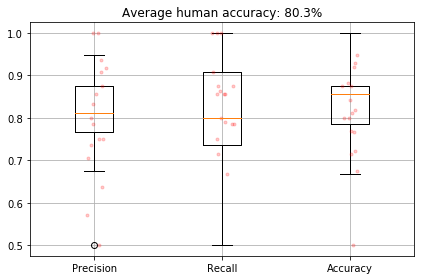

In [187]:
fig, ax = plt.subplots()
ax.boxplot([es,p,r])
for i, ys in enumerate([p,r,es]):
    x = np.random.normal(i+1, 0.04, size=len(ys))
    ax.plot(x, ys, 'r.', alpha=0.2)
ax.set_xticklabels(["Precision","Recall","Accuracy"])    
ax.set_title(f"Average human accuracy: {np.mean(es):.1%}")
ax.grid()
fig.tight_layout()

plt.savefig("../plots/human_accuracy.png")
plt.savefig("../plots/human_accuracy.pdf")

In [108]:
p = Project.objects.get(pk=pid)
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=list(multi_df['id']),category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
print(dudf_wide.shape)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()
dudf_wide_r = dudf_wide.reset_index()
dudf_wide_r.columns = ["doc__id",'user__username'] + list(dudf_wide.columns)
dudf_expanded = dudf_wide_r.melt(id_vars=["doc__id","user__username"]).head()
print(gudf.shape)
gudf.tail()

(245, 85)
(60, 86)


cname,doc__id,10 - places,11 - Africa,11 - Asia,11 - Australasia,11 - Central & South America,11 - Europe,11 - Global,11 - North America,11 - Open ocean,...,8 - 8.03. Quantitative - process-based modelling,8 - 8.04. Quantitative - empirical models,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations
55,1910942,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,2153334,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
57,2185223,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,2316858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,2356661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
dudf_wide_r

,doc__id,user__username,10 - places,11 - Africa,11 - Asia,11 - Australasia,11 - Central & South America,11 - Europe,11 - Global,11 - North America,...,8 - 8.03. Quantitative - process-based modelling,8 - 8.04. Quantitative - empirical models,8 - 8.05. Quantitative - statistical,8 - 8.06. Qualitative - literature review,8 - 8.07. Qualitative - expert interviews,8 - 8.08. Qualitative - household surveys,8 - 8.09. Mixed methods,8 - 8.10. Case studies,8 - 8.11. Remote sensing,9 - observations
0,9802,carl.schleussner@climateanalytics.org,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,9802,emily.theokritoff@climateanalytics.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18654,chelsea.jones@climateanalytics.org,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,18654,quentin.lejeune@climateanalytics.org,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21611,agathe.lucas@climateanalytics.org,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2356661,kaylin.lee@climateanalytics.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241,2356661,marina.andrijevic@climateanalytics.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,2356661,michael.hegarty@climateanalytics.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
243,2356661,peter.pfleiderer@climateanalytics.org,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
for c in cats:
    cname = f"{c.level} - {c.name}"
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname not in dudf_wide_r.columns:
            continue
        dudf_wide_r.loc[dudf_wide_r[ecname]==1,cname] = 1  
        gudf.loc[gudf[ecname]==1,cname] = 1  
            


In [182]:
stats = []
for c in cats:
    cname = f"{c.level} - {c.name}"
    p = {"name":f"precision","x":[]}
    r = {"name":f"recall","x":[]}
    for user, group in dudf_wide_r.groupby('user__username'):
        if group.shape[0]<2:
            continue   
            
        mdf = pd.merge(gudf[["doc__id",cname]], group[["doc__id",cname]].dropna().rename(columns={cname:user})[['doc__id',user]],how="left").fillna(0)
        mdf = mdf.loc[mdf["doc__id"].isin(dodf.loc[dodf['user__username']==user,"doc_id"])]
        cname = f"{c.level} - {c.name}"
        y_pred = mdf[user]
        y_true = mdf[cname]
        p["x"].append(precision_score(y_true,y_pred))
        r["x"].append(recall_score(y_true,y_pred))
        
    stats += [p,r]

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


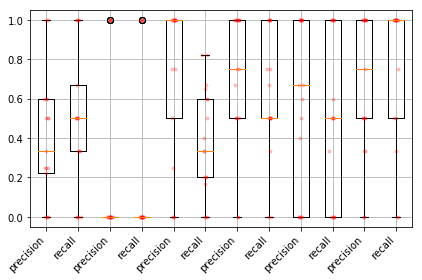

In [183]:
fig, ax = plt.subplots()
ax.boxplot([s["x"] for s in stats])
ticks = []
for i, s in enumerate(stats):
    ys = s["x"]
    ticks.append(s["name"])
    x = np.random.normal(i+1, 0.04, size=len(ys))
    ax.plot(x, ys, 'r.', alpha=0.2)
#ax.set_xticklabels(["Accuracty","Precision","Recall"])    
#ax.set_title(f"Average human accuracy: {np.mean(es):.1%}")
ax.set_xticklabels(ticks,rotation=45,ha="right")
ax.grid()
fig.tight_layout()

In [170]:
stats

[{'name': 'Physical systems - precision', 'x': [0.5]},
 {'name': 'Physical systems - recall', 'x': [0.3333333333333333]},
 {'name': 'Mountains, snow and ice - precision', 'x': [0.0]},
 {'name': 'Mountains, snow and ice - recall', 'x': [0.0]},
 {'name': 'Rivers, lakes, and soil moisture - precision', 'x': [1.0]},
 {'name': 'Rivers, lakes, and soil moisture - recall',
  'x': [0.8235294117647058]},
 {'name': 'Coastal and marine Ecosystems - precision', 'x': [1.0]},
 {'name': 'Coastal and marine Ecosystems - recall', 'x': [0.5]},
 {'name': 'Terrestrial ES - precision', 'x': [1.0]},
 {'name': 'Terrestrial ES - recall', 'x': [0.5]},
 {'name': 'Human and managed - precision', 'x': [0.5]},
 {'name': 'Human and managed - recall', 'x': [1.0]}]